# Steam Game Review Sentiment Analysis <a class="anchor" id="chapter0"></a>

### Table of Contents
* [Introduction](#chapter1)
* [Conclusion / Results](#chapter2)
* [EDA](#chapter3)
    - [Visualization](#section_3_1)
* [Data Cleaning](#chapter4)
* [Modeling](#chapter5)
    - [Logistic Regression](#section_5_1)
    - [Multinomial Naive Bayes](#section_5_2)
    - [Random Forest](#section_5_3)

### Introduction / Motivation <a class="anchor" id="chapter1"></a>
Steam is a video game digital distribution service for PC platform. The products on Steam are rated by players in the form of comments or reviews. These reviews can be a good indicator for other players how good the product is. In this case, those reviews can be used to do sentiment analysis using machine learning. Sentiment analysis can be useful to monitor product sentiment from player feedback.

### About the Data
This project used 'Steam Reviews' dataset that was downloaded from [Kaggle](https://www.kaggle.com/datasets/andrewmvd/steam-reviews).
'Steam Reviews' dataset has about 6.4 million rows and 6 columns (`app_id`, `app_name`, `review_text`, `review_score`, `review_votes`). Of the 6 features, only `review_text` and `review_score` features are used. Also 'Steam Reviews' dataset is an unbalanced dataset.

### Goal
Goal of this project is to create model that can classify positive sentiment (positive review) and negative sentiment (negative review) base d on dataset that already mentioned above. There will be a performance comparison between 3 model: **Logistic Regression, Multinomial Naive Bayes and Random Forest Classifier**. The 3 models will then be evaluated using **F1-Score and ROC-AUC score**.

### Why use F1-Score and ROC-AUC?
F1-Score enable us to take into account about false negative and false positive when calculating model accuracy rather than use generic accuracy score method. As for ROC-AUC allow us to see how good the model when classifying unbalanced data by comparing true positive rate value and false positive rate value.

### Conclusion / Results <a class="anchor" id="chapter2"></a>
Through this project, all 3 model was able to be fitted where Logistic Regression model produces highest F1-Score and ROC-AUC around 0.8 and 0.77, respectively. Multinomial Naive Bayes had the lowest F1-Score of 0.49 and ROC-AUC of 0.52 while Random Forest model had F1-Score of 0.63 and ROC-AUC of 0.60. The result of the three model are presented below in the form of a table:

|Model|F1-Score|ROC-AUC|
|---|---|---|
|Logistic Regression|**0.8003524874981843**|**0.7682825262448604**|
|Multinomial Naive Bayes|0.488701288813998|0.5182127762195058|
|Random Forest|0.6270504131555521|0.6009745157160985|

[Back to Table of Contents](#chapter0)

# EDA <a class="anchor" id="chapter3"></a>

Import library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from wordcloud import WordCloud

Only take 5% of the data because dataset is quite large 

In [2]:
random.seed(7)
p = 0.05
df = pd.read_csv("dataset.csv", skiprows=lambda i: i>0 and random.random() > p)
df.head(5)

,app_id,app_name,review_text,review_score,review_votes
0,10,Counter-Strike,"Counter-Strike: Ok, after 9 years of unlimited...",1,1
1,10,Counter-Strike,Playing it since 2010. Still bad at it. 10/1...,1,1
2,10,Counter-Strike,It's a real legend .. legend of PC games,1,1
3,10,Counter-Strike,'Playing Since 2006 (non-steam/steam) more tha...,1,1
4,10,Counter-Strike,"A still alive first-person shooter, since 2000...",1,0


Load dataset and see first five data

Show dataset info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321042 entries, 0 to 321041
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   app_id        321042 non-null  int64 
 1   app_name      311852 non-null  object
 2   review_text   320669 non-null  object
 3   review_score  321042 non-null  int64 
 4   review_votes  321042 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ MB


In [4]:
df.shape

(321042, 5)

The `review_text` have type of object so need to convert it into string

In [5]:
df["review_text"] = df["review_text"].astype(str)

Count each class value

In [6]:
df.review_score.value_counts()

 1    263060
-1     57982
Name: review_score, dtype: int64

Change the label value from 1 for positive and -1 for negative to 0 for negative and 1 for positive to make evaluating model later easier

In [7]:
df["review_score"] = np.where(df["review_score"]==-1, 0, df["review_score"])
df.review_score.value_counts()

1    263060
0     57982
Name: review_score, dtype: int64

Convert value counts into percentage

In [8]:
df.review_score.value_counts(normalize=True)

1    0.819394
0    0.180606
Name: review_score, dtype: float64

Check if there is null value somewhere in dataset

In [9]:
df.isna().any()

app_id          False
app_name         True
review_text     False
review_score    False
review_votes    False
dtype: bool

it is shown that there are no null value in the data except within the `app_name` column, but it is okay to ignore that because the main feature used here is the `review_text` column

In [10]:
df.describe()

,app_id,review_score,review_votes
count,321042.000000,321042.000000,321042.000000
mean,227429.662571,0.819394,0.147224
std,126153.934082,0.384692,0.354329
min,10.000000,0.000000,0.000000
25%,201810.000000,1.000000,0.000000
50%,239350.000000,1.000000,0.000000
75%,305620.000000,1.000000,0.000000
max,563430.000000,1.000000,1.000000


Find if there is duplicated data

In [11]:
df[df.duplicated()].shape

(50849, 5)

Drop duplicated rows

In [12]:
df.drop_duplicates(["review_text", "review_score"], inplace=True, keep="first")
df.shape

(261830, 5)

[Back to Table of Contents](#chapter0)

## Visualization <a class="anchor" id="section_3_1"></a>

Visualize count of each label using countplot

<AxesSubplot:xlabel='review_score', ylabel='count'>

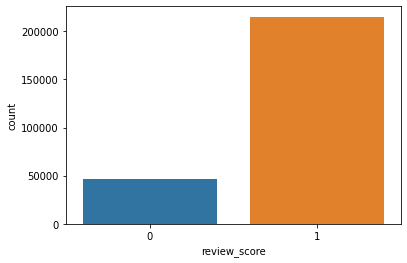

In [13]:
sns.countplot(x="review_score", data=df)

#### Generate Wordcloud for dataset

Generate wordcloud from whole dataset to see dominant word, dataset hasn't been cleaned yet so it still contain lot of stopwords

*STOPWORDS is a list of frequently used words thus those words did not provide additional information to model and only become noise that make training process slow*

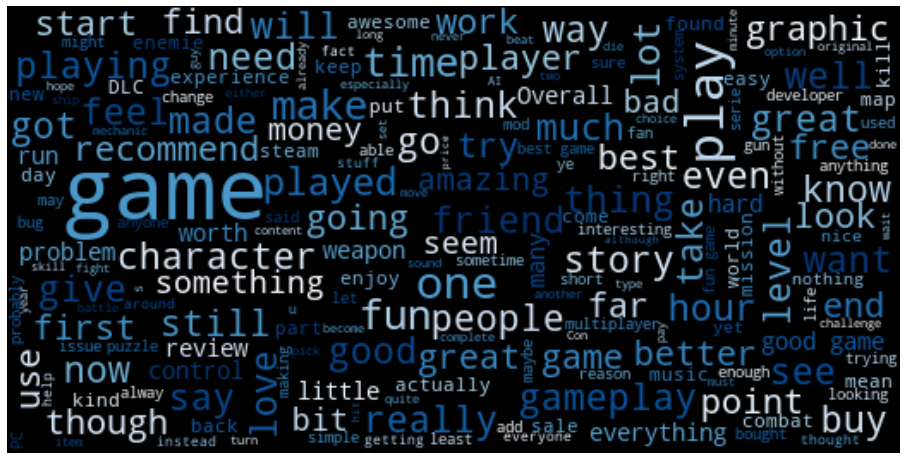

In [14]:
review_text = df["review_text"]
review_text = " ".join(review_text.to_numpy().tolist())
review_text_cloud = WordCloud(width=520, height=260, max_font_size=50, background_color="black", colormap="Blues").generate(review_text)
plt.figure(figsize=(16, 10))
plt.imshow(review_text_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

From picture above, we can see that from overall review that the most common word is **'game'**, **'play'**, **'recommend'**, etc.

**Generate wordcloud for negative review**

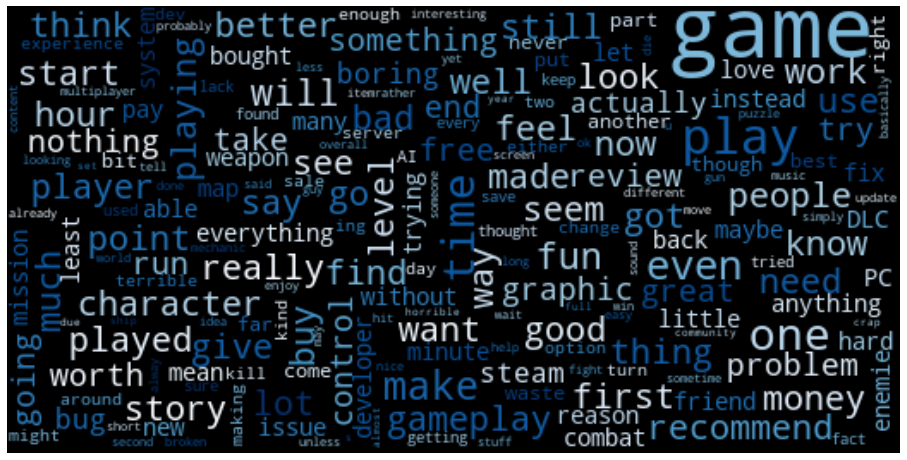

In [15]:
positive_df = df[df.review_score == 0]
positive_text = " ".join(positive_df.review_text.to_numpy().tolist())
positive_text_cloud = WordCloud(width=520, height=260, max_font_size=50, background_color="black", colormap="Blues").generate(positive_text)
plt.figure(figsize=(16, 10))
plt.imshow(positive_text_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

As we can see that for negative sentiment review, some of common word is **'bug'**, **'bad'**, **'problem'**, **'boring'**, etc as shown in picture above.

**Generate wordcloud for positive review**

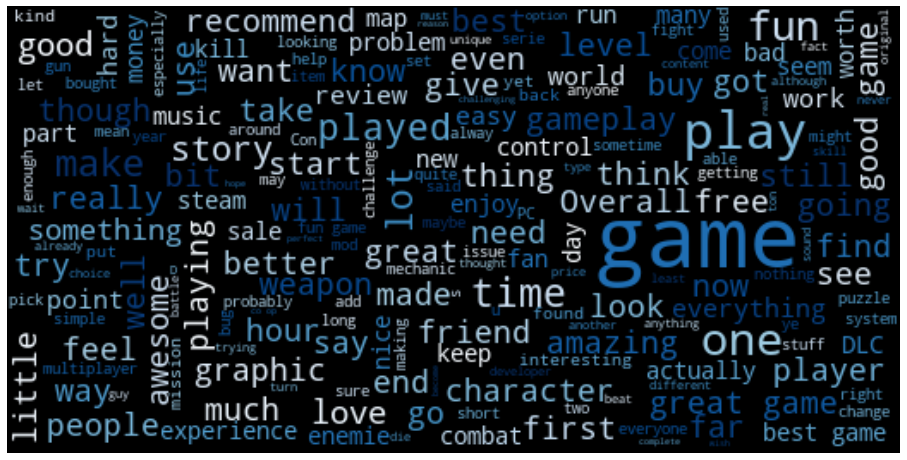

In [16]:
negative_df = df[df.review_score == 1]
negative_text = " ".join(negative_df.review_text.to_numpy().tolist())
negative_text_cloud = WordCloud(width=520, height=260, max_font_size=50, background_color="black", colormap="Blues").generate(negative_text)
plt.figure(figsize=(16, 10))
plt.imshow(negative_text_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

For positive sentiment review, some of common word is **'fun'**, **'love'**, **'great'**, **'best'**, etc as shown in picture above.

[Back to Table of Contents](#chapter0)

# Data Cleaning <a class="anchor" id="chapter4"></a>

In [17]:
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer
# nltk.download("stopwords")
# nltk.download("punkt")

Create a function to show confusion matrix after each model test

In [18]:
def model_conf_mat(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    print(f"True positive: {conf_mat[0, 0]}")
    print(f"False positive: {conf_mat[1, 0]}")
    print(f"True negative: {conf_mat[1, 1]}")
    print(f"False negative: {conf_mat[0, 1]}")
    plt.figure(figsize=(7,5))
    sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt="g")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("Actual label")
    plt.show()

Create a function to clean dataset from:
* Character like symbol
* Stopwords
* Trailing space
* Numeric

Also we need to convert all letter in the text to be lowercase

In [19]:
import re
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))
def clean_text(text: str):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = re.sub(r'\W+', ' ', text) 
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

Create a function to stem words back to its root form

In [20]:
from nltk.stem.porter import PorterStemmer
def stem_text(text: str):
    stem = []
    stemmer = PorterStemmer()
    word_token = nltk.word_tokenize(text)
    stemmed = [stemmer.stem(word) for word in word_token]
    stem=' '.join(stemmed)
    return stem

Create a function to apply 2 previously made function into dataset

In [21]:
def clean_data(data, review):
    data[review] = df[review].apply(clean_text)
    data[review] = df[review].apply(stem_text)

Get first 10 data to see how it looks like before cleaning

In [22]:
df[["review_text"]].head(10)

,review_text
0,"Counter-Strike: Ok, after 9 years of unlimited..."
1,Playing it since 2010. Still bad at it. 10/1...
2,It's a real legend .. legend of PC games
3,'Playing Since 2006 (non-steam/steam) more tha...
4,"A still alive first-person shooter, since 2000..."
5,Quake was the first game I was ever really add...
6,How to end your life Step 1 - Download this g...
7,Everyone Gets Grenades Fire In The Hole Fire I...
8,Counter-Strike is a first-person shooter game ...
9,Great game. A must have for any Steam user.


In [23]:
clean_data(df, "review_text")

In [24]:
df[["review_text"]].head(10)

,review_text
0,counterstrik ok 9 year unlimit fun friend fina...
1,play sinc 2010 still bad 10 10 best game cs seri
2,real legend legend pc game
3,play sinc 2006 nonsteam steam 3k hour other ti...
4,still aliv firstperson shooter sinc 2000 game ...
5,quak first game ever realli addict focus big p...
6,end life step 1 download game done
7,everyon get grenad fire hole fire hole fire ho...
8,counterstrik firstperson shooter game valv fir...
9,great game must steam user


**First 10 data after cleaning done**

Bellow we create a function to evaluate model performance by calculating:
* Accuracy
* Precision
* Recall
* F1-Score

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred) * 100
    prec, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="macro")
    model_result = {"accuracy": acc,
                    "precision": prec,
                    "recall": recall,
                    "F1-Score": f1}
    print(classification_report(y_true, y_pred))
    return model_result

Here we split dataset into x and y, where x contain `review_text` column and y contain label from `review_score` column

In [26]:
x = df["review_text"]
y = df["review_score"]

Create another function to calculate and plot ROC-AUC score and curve

In [27]:
def model_roc(y_true, y_pred, average="macro"):
    fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(f"ROC AUC score: {roc_auc_score(y_test, y_pred, average=average)}")
    c_ax.plot(fpr[1], fpr[1], "k-", label = "random guessing")
    c_ax.plot(fpr[1], tpr[1], label="AUC:%0.2f" % roc_auc_score(y_test, y_pred, average=average))
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    c_ax.set_title('Receiver operating characteristic')
    c_ax.legend()
    plt.show()

Create a pipeline function

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

def create_pipeline(clf):
    model = Pipeline([
        ('vect', TfidfVectorizer(strip_accents=None, lowercase=False, preprocessor=None)),
         ('clf', clf)
    ])
    return model

In [29]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=7)

[Back to Table of Contents](#chapter0)

# Modeling <a class="anchor" id="chapter5"></a>

## Logistic Regression <a class="anchor" id="section_5_1"></a>

In [30]:
from sklearn.linear_model import LogisticRegression
lr_tfidf = create_pipeline(LogisticRegression(random_state=0, solver="liblinear"))
lr = lr_tfidf.fit(x_train, y_train)
lr_pred = lr.predict(x_test)

#### Model Performance

In [31]:
result = evaluate_model(y_test, lr_pred)
result

              precision    recall  f1-score   support

           0       0.79      0.57      0.66      9278
           1       0.91      0.97      0.94     43088

    accuracy                           0.90     52366
   macro avg       0.85      0.77      0.80     52366
weighted avg       0.89      0.90      0.89     52366



{'accuracy': 89.68223656571057,
 'precision': 0.8511196867636417,
 'recall': 0.7682825262448603,
 'F1-Score': 0.8003524874981843}

True positive: 5281
False positive: 1406
True negative: 41682
False negative: 3997


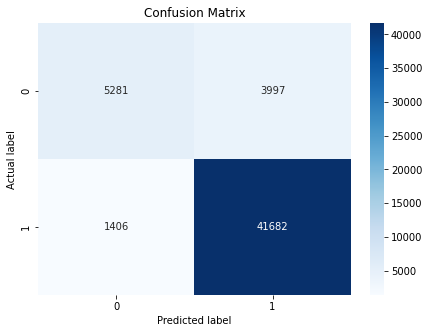

In [32]:
model_conf_mat(y_test, lr_pred)

**We can see from above confusion matrix for this Logistic Regression model has 89% accuracy and 0.8 F1-Score, but if we take a look at individual F1-Score for each class, it is shown that this model doing poorly at predicting negative class.**

**Bellow we have ROC-AUC score and curve with score of 0.768. This means that model can still distinguish positive statement and negative statement but not very accurate.**

ROC AUC score: 0.7682825262448604


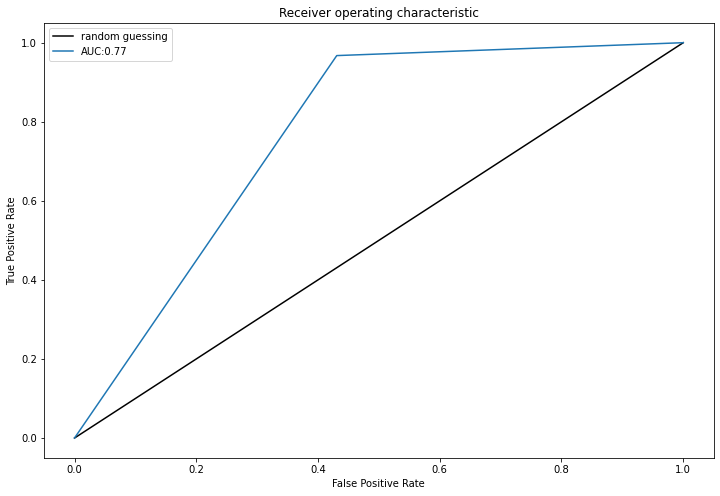

In [33]:
model_roc(y_test, lr_pred)

[Back to Table of Contents](#chapter0)

## Multinomial Naive Bayes <a class="anchor" id="section_5_2"></a>

In [34]:
from sklearn.naive_bayes import MultinomialNB
mnb_tfidf = create_pipeline(MultinomialNB())
mnb = mnb_tfidf.fit(x_train, y_train)
mnb_pred = mnb.predict(x_test)

#### Model Performance

In [35]:
result = evaluate_model(y_test, mnb_pred)
result

              precision    recall  f1-score   support

           0       0.89      0.04      0.07      9278
           1       0.83      1.00      0.91     43088

    accuracy                           0.83     52366
   macro avg       0.86      0.52      0.49     52366
weighted avg       0.84      0.83      0.76     52366



{'accuracy': 82.86483596226559,
 'precision': 0.8601024241837637,
 'recall': 0.5182127762195058,
 'F1-Score': 0.488701288813998}

True positive: 347
False positive: 42
True negative: 43046
False negative: 8931


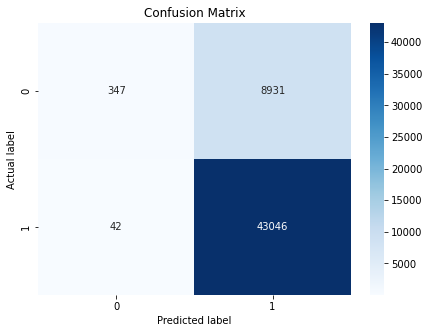

In [36]:
model_conf_mat(y_test, mnb_pred)

**As we can see from the result above, Multinomial Naive Bayes model has really high accuracy score of 82.8% but low F1-Score of 0.488. High accuracy score because the unbalanced dataset that make positive label more dominant when accuracy calculated. It is shown that from F1-Score that this model did not perform really well to classify between positive and negative sentiment**

**From ROC-AUC score and graph bellow, Multinomial Naive Bayes has 0.518 ROC-AUC Score. This means that this model when tasked to classify new data will resulting positive or negative with chance 50:50 (random guessing like flipping coin).**

ROC AUC score: 0.5182127762195058


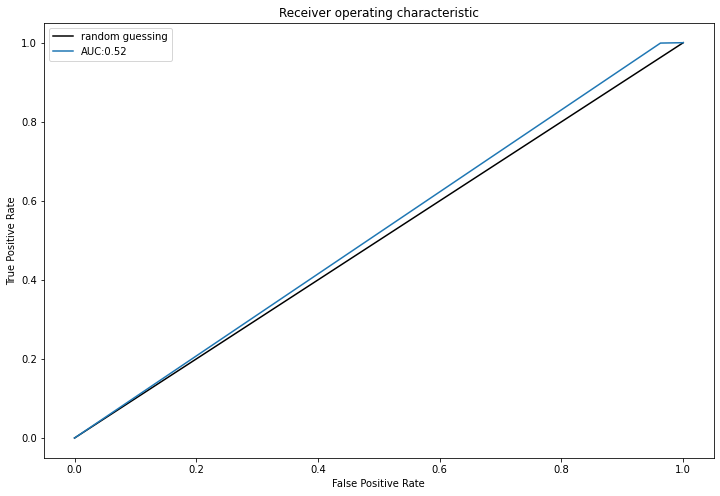

In [37]:
model_roc(y_test, mnb_pred)

[Back to Table of Contents](#chapter0)

## Random Forest <a class="anchor" id="section_5_3"></a>

In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc_tfidf = create_pipeline(RandomForestClassifier())
rfc = rfc_tfidf.fit(x_train, y_train)
rfc_pred = rfc.predict(x_test)

In [39]:
result = evaluate_model(y_test, rfc_pred)
result

              precision    recall  f1-score   support

           0       0.84      0.21      0.34      9278
           1       0.85      0.99      0.92     43088

    accuracy                           0.85     52366
   macro avg       0.85      0.60      0.63     52366
weighted avg       0.85      0.85      0.81     52366



{'accuracy': 85.30153152809075,
 'precision': 0.8466709718031453,
 'recall': 0.6009745157160985,
 'F1-Score': 0.6270504131555521}

True positive: 1954
False positive: 373
True negative: 42715
False negative: 7324


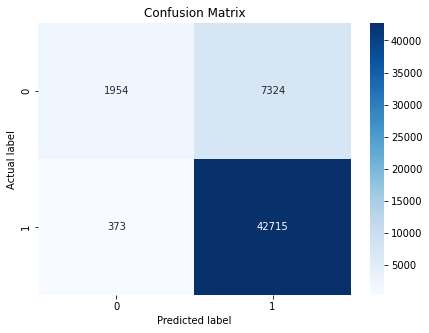

In [40]:
model_conf_mat(y_test, rfc_pred)

**As for the last model, Random Forest Classifier has accuracy score of 85.3% and F1-Score of 0.63 which is slightly high than Multinomial Naive Bayes model.**

**Random Forest Classifier has ROC-AUC score of 0.60 and come second best after Logistic Regression model but this score is still low and will not perform well with new data.**

ROC AUC score: 0.6009745157160985


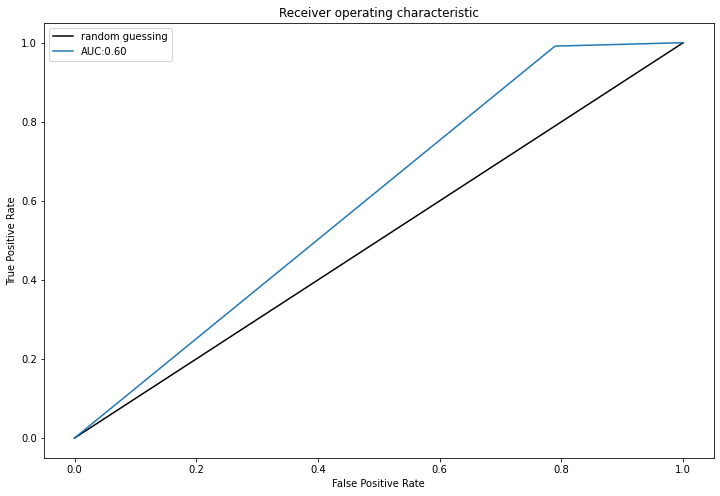

In [41]:
model_roc(y_test, rfc_pred)

[Back to Table of Contents](#chapter0)